In [578]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
%matplotlib inline
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

In [579]:
# Assigning column names to the DataFrame
columns = ['Year', 'Sunspot Mean', 'Std Dev', 'Num Observations', 'Status']
yearly_data = pd.read_csv("/Users/farhana/Downloads/Introduction to Data Science/Class Lectures/Projects/Project 3/SN_y_tot_V2.0.csv", sep=";", header=None, names=columns)
yearly_data.head()

,Year,Sunspot Mean,Std Dev,Num Observations,Status
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [580]:
# Replacing -1 in 'Mean Sunspot Number' with NaN
yearly_data['Sunspot Mean'] = yearly_data['Sunspot Mean'].replace(-1, pd.NA)

# Converting the Year column to integers
yearly_data['Year'] = yearly_data['Year'].astype(int)
print(yearly_data.head())

   Year  Sunspot Mean  Std Dev  Num Observations  Status
0  1700           8.3     -1.0                -1       1
1  1701          18.3     -1.0                -1       1
2  1702          26.7     -1.0                -1       1
3  1703          38.3     -1.0                -1       1
4  1704          60.0     -1.0                -1       1


In [581]:
# Using forward fill to replace NaN values with the last valid value
yearly_data['Sunspot Mean'] = yearly_data['Sunspot Mean'].fillna(method='ffill')

In [582]:
# Converting Year to datetime format (use January 1st of each year)
yearly_data['ds'] = pd.to_datetime(yearly_data['Year'], format='%Y')

# Creating the time series dataframe
df_prophet = yearly_data[['ds', 'Sunspot Mean']].rename(columns={'Sunspot Mean': 'y'})
print(df_prophet.head())

          ds     y
0 1700-01-01   8.3
1 1701-01-01  18.3
2 1702-01-01  26.7
3 1703-01-01  38.3
4 1704-01-01  60.0


# Line plot for sunspot data

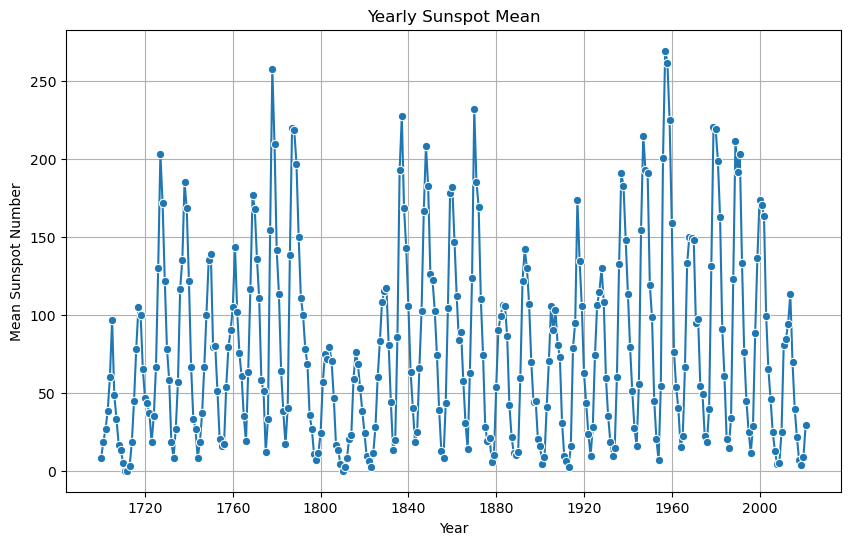

In [583]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_prophet, x='ds', y='y', marker='o')

plt.title('Yearly Sunspot Mean')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.grid(True)
plt.show()

# Distribution of Yearly Mean Sunspot Numbers

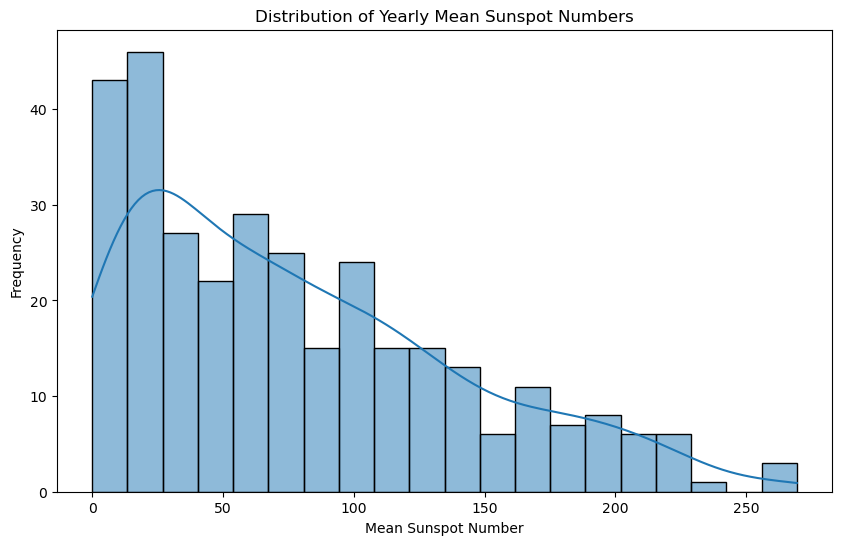

In [584]:
plt.figure(figsize=(10, 6))
sns.histplot(df_prophet['y'], bins=20, kde=True)

plt.title('Distribution of Yearly Mean Sunspot Numbers')
plt.xlabel('Mean Sunspot Number')
plt.ylabel('Frequency')

plt.show()

# Calculating rolling mean with a window of 5 years

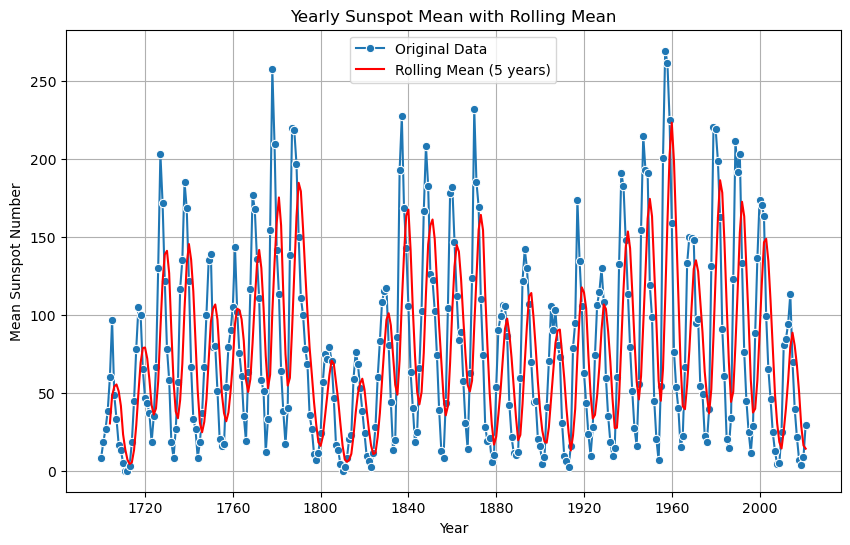

In [585]:
df_prophet['Rolling Mean'] = df_prophet['y'].rolling(window=5).mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_prophet, x='ds', y='y', label='Original Data', marker='o')
sns.lineplot(data=df_prophet, x='ds', y='Rolling Mean', label='Rolling Mean (5 years)', color='red')

plt.title('Yearly Sunspot Mean with Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.legend()
plt.grid(True)

plt.show()

# Decomposition of the time series

<Figure size 1200x800 with 0 Axes>

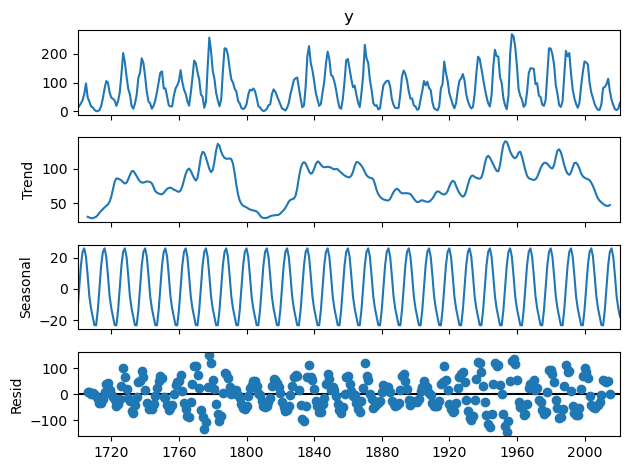

In [586]:
df_prophet.set_index('ds', inplace=True)
decomposition = seasonal_decompose(df_prophet['y'], model='additive', period=12)

plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

In [587]:
# checking the index for the start and end year
start_year = df_prophet.index.min().year
end_year = df_prophet.index.max().year

print(f"Start Year: {start_year}")
print(f"End Year: {end_year}")

Start Year: 1700
End Year: 2021


In [588]:
# Ensuring the index (ds) is in datetime format
df_prophet.index = pd.to_datetime(df_prophet.index, errors='coerce')

# Filtering rows where index (ds) is >= 1800-01-01
df_prophet = df_prophet[df_prophet.index >= pd.to_datetime("1800-01-01")]

print(df_prophet.head())
print(df_prophet.index.min())

               y  Rolling Mean
ds                            
1800-01-01  24.2         15.94
1801-01-01  56.7         21.94
1802-01-01  75.0         34.80
1803-01-01  71.8         47.80
1804-01-01  79.2         61.38
1800-01-01 00:00:00


In [589]:
# Keeping only 'ds' and 'y' columns
df_prophet = df_prophet.reset_index()[['ds', 'y']]

print(df_prophet.head())

          ds     y
0 1800-01-01  24.2
1 1801-01-01  56.7
2 1802-01-01  75.0
3 1803-01-01  71.8
4 1804-01-01  79.2


In [590]:
# Splitting the data into training and testing sets
train_size = int(len(df_prophet) * 0.8)  # 80% for training
df_train = df_prophet.iloc[:train_size]
df_test = df_prophet.iloc[train_size:]

print(f"Training Data:\n{df_train.tail()}")
print(f"Testing Data:\n{df_test.head()}")

Training Data:
            ds     y
172 1972-01-01  97.6
173 1973-01-01  54.1
174 1974-01-01  49.2
175 1975-01-01  22.5
176 1976-01-01  18.4
Testing Data:
            ds      y
177 1977-01-01   39.3
178 1978-01-01  131.0
179 1979-01-01  220.1
180 1980-01-01  218.9
181 1981-01-01  198.9


# Removing Outliers

In [591]:
# Removing outliers based on quantile thresholds
q_low = df_train['y'].quantile(0.01)  # 1st percentile
q_high = df_train['y'].quantile(0.99)  # 99th percentile
df_train = df_train[(df_train['y'] > q_low) & (df_train['y'] < q_high)]

# Model Training

In [592]:
# Model training 
model = Prophet(
    growth='linear',               
    yearly_seasonality=False,       
    seasonality_mode='multiplicative',  
    changepoint_prior_scale=0.005,  
    seasonality_prior_scale=15,     
    interval_width=0.95            
)

model.add_seasonality(
    name='custom_yearly',
    period=365.25,  
    fourier_order=15  
)

model.add_seasonality(
    name='long_term_cycle',
    period=365.25 * 11,  
    fourier_order=6  
)


In [593]:
# Fit the model to training data
model.fit(df_train)

22:20:08 - cmdstanpy - INFO - Chain [1] start processing
22:20:08 - cmdstanpy - INFO - Chain [1] done processing
22:20:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:20:08 - cmdstanpy - INFO - Chain [1] start processing
22:20:08 - cmdstanpy - INFO - Chain [1] done processing


# Forcasting with Prophet

In [594]:
# Forcasting with Prophet
start_date = df_test['ds'].min()  
end_date = df_test['ds'].min() + pd.DateOffset(years=10)  

df_future = pd.date_range(start=start_date, end=end_date, freq='Y')

df_future = pd.DataFrame(df_future, columns=['ds'])

df_future['ds'] = df_future['ds'].apply(lambda x: x.replace(month=1, day=1))
forecast = model.predict(df_future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

          ds        yhat  yhat_lower  yhat_upper
0 1977-01-01   27.309272  -43.737845  105.179592
1 1978-01-01   64.082723  -13.854895  145.763836
2 1979-01-01   97.025401   18.086366  170.010686
3 1980-01-01  155.135673   77.283377  230.892928
4 1981-01-01  170.877209   93.724761  252.591537
5 1982-01-01  151.799687   77.176651  230.375167
6 1983-01-01  129.462838   50.808437  208.256711
7 1984-01-01   96.711759   17.013575  177.760005
8 1985-01-01   65.939947  -11.286592  147.829549
9 1986-01-01   37.403151  -47.466345  115.506184


# Evaluating The Model 

In [595]:
df_test_merged = pd.merge(df_test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')

mae = mean_absolute_error(df_test_merged['y'], df_test_merged['yhat'])
print(f"Mean Absolute Error (MAE): {mae}")

rmse = np.sqrt(mean_squared_error(df_test_merged['y'], df_test_merged['yhat']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

mape = np.mean(np.abs((df_test_merged['y'] - df_test_merged['yhat']) / df_test_merged['y'])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

from sklearn.metrics import r2_score
r2 = r2_score(df_test_merged['y'], df_test_merged['yhat'])
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 44.698773165060445
Root Mean Squared Error (RMSE): 54.85424697612175
Mean Absolute Percentage Error (MAPE): 66.21976621262664%
R-squared (R²): 0.49518449428333033


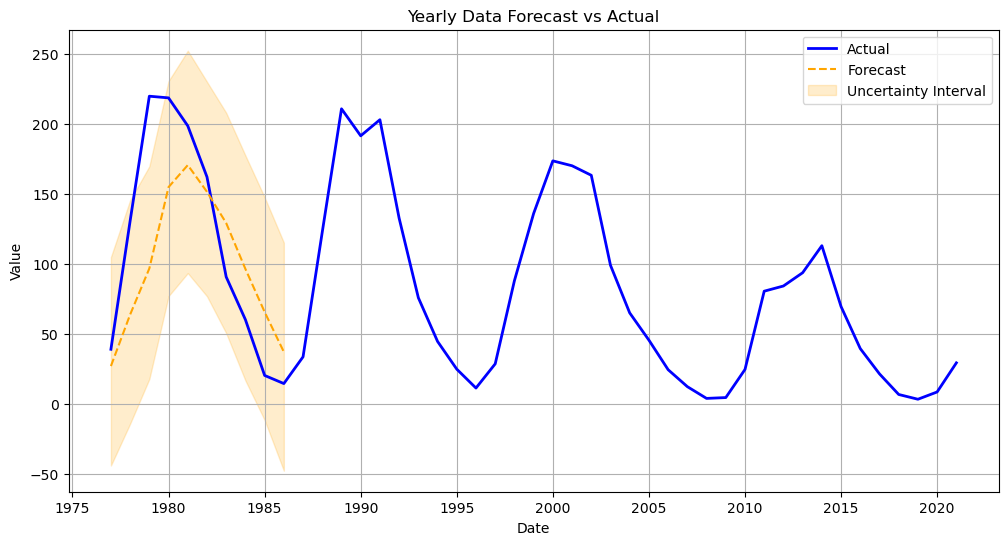

In [596]:
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_test['ds'], df_test['y'], label='Actual', color='blue', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange', linestyle='--')
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='orange',
    alpha=0.2,
    label='Uncertainty Interval'
)
plt.title('Yearly Data Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

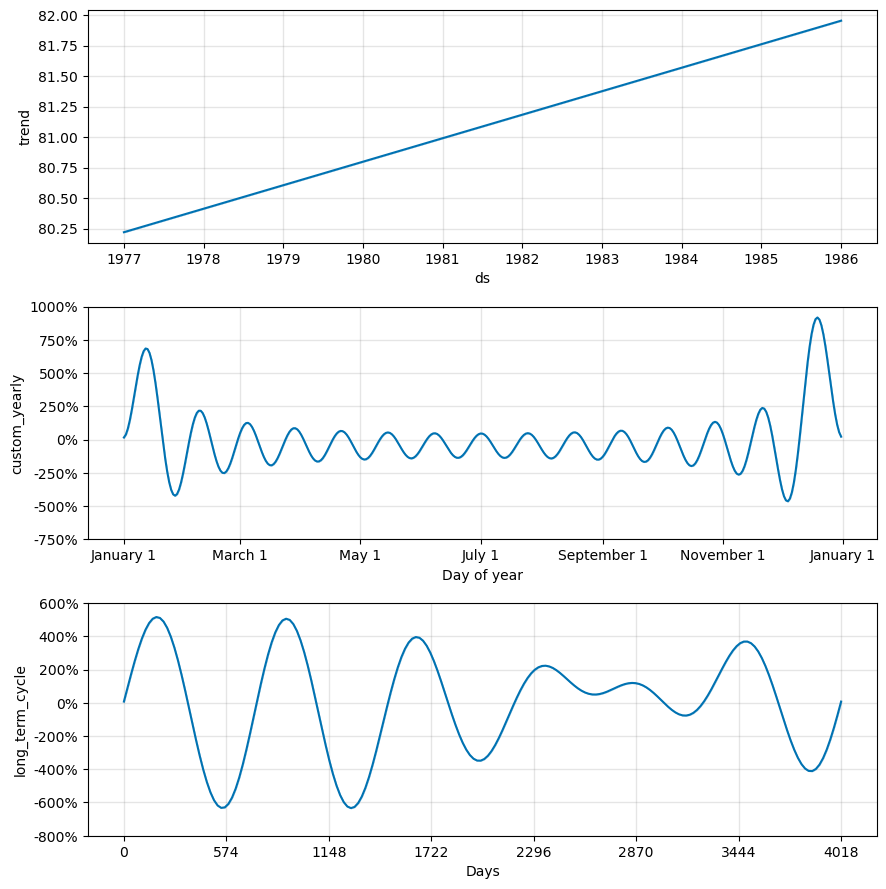

In [597]:
# Plotting the forecast components 
fig_components = model.plot_components(forecast)
plt.show()